# Figure 5 - Reaction mechanism determination

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as optimize

import ast

import pymc3 as pm
import arviz as az
import theano.tensor as tt

import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set_theme(style='ticks', context='paper', font_scale=0.8);

%reload_ext watermark
%watermark -a "Mathieu Baltussen" -d -t -u -v -iv

Author: Mathieu Baltussen

Last updated: 2022-02-02 10:28:29

Python implementation: CPython
Python version       : 3.9.5
IPython version      : 7.28.0

seaborn   : 0.11.1
pandas    : 1.2.4
theano    : 1.1.2
numpy     : 1.20.3
arviz     : 0.11.4
networkx  : 2.6.3
scipy     : 1.6.2
matplotlib: 3.4.2
sys       : 3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:32:32) 
[GCC 9.3.0]
pymc3     : 3.11.4



## Helper functions for plotting

In [2]:
def savefig(name):
    plt.savefig(f"../figures/{name}.svg")
    plt.savefig(f"../figures/{name}.png", dpi=300)

XSIZE = 7.0 #inch
YSIZE = XSIZE/np.sqrt(2) #inch

def generate_figure(n_col, n_row):
    DX = XSIZE/n_col
    DY = YSIZE/n_col
    YLENGTH = n_row*DY

    fig = plt.figure(figsize=(XSIZE, YLENGTH), constrained_layout=True)
    gs = fig.add_gridspec(n_row, n_col)
    return fig, gs


## Data loading

In [35]:
experiments = pd.read_csv(f"../data/kinetic_studies.csv").query(
    f'enzyme == "G6PDH"'
)
data = []
for t in experiments.itertuples():
    df = pd.read_csv(f"../data/{t.data_path}")
    df = df.assign(
        kf=t.flowrate / (60 * t.volume),
        G6PDH=t.enzyme_concentration,
        code=t.experiment_code,
    )
    data.append(df)

data = pd.concat(data).reset_index(drop=True)

data = data.assign(
    NAD_obs=data.NAD_in - data.NADH_obs,
    G6P_obs=data.G6P_in - data.NADH_obs,
    G6PdL_obs=data.NADH_obs
)

## Creation of models

In [36]:
exp_idx, exp_coords = data.code.factorize(sort=True)
obs_idx, obs_coords = data.index.factorize(sort=True)
coords = {"exp": exp_coords, 'obs': obs_coords}

with pm.Model(coords=coords) as model_0:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_G6P = pm.Uniform("K_G6P", 1, 4000)
    K_NAD = pm.Uniform("K_NAD", 1, 2000)
    # KI_NADH = pm.Uniform("KI_NADH", 1, 5000)

    sigma = pm.Exponential("sigma", 0.5, dims='exp')

    G6PDH = data.G6PDH.values
    NADH = data.NADH_obs.values
    NAD = data.NAD_obs.values

    G6P = data.G6P_obs.values
    G6PdL = data.G6PdL_obs.values

    G6P_in = data.G6P_in.values
    NAD_in = data.NAD_in.values
    kf = data.kf.values

    NADH_obs = pm.Normal("NADH_obs", 
                mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*(1 + G6P/K_G6P)*(1+NAD/K_NAD)),
                sigma=sigma[exp_idx],
                observed= NADH
                )

with pm.Model(coords=coords) as model_1:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_G6P = pm.Uniform("K_G6P", 1, 4000)
    K_NAD = pm.Uniform("K_NAD", 1, 2000)
    KI_NADH = pm.Uniform("KI_NADH", 1, 10000)

    sigma = pm.Exponential("sigma", 0.5, dims='exp')


    G6PDH = data.G6PDH.values
    NADH = data.NADH_obs.values
    NAD = data.NAD_obs.values

    G6P = data.G6P_obs.values
    G6PdL = data.G6PdL_obs.values

    G6P_in = data.G6P_in.values
    NAD_in = data.NAD_in.values
    kf = data.kf.values

    NADH_obs = pm.Normal("NADH_obs", 
                mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*(1 + G6P/K_G6P)*(1+NAD/K_NAD)*(1+ NADH/KI_NADH)),
                sigma=sigma[exp_idx],
                observed= NADH
                )

with pm.Model(coords=coords) as model_2:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_G6P = pm.Uniform("K_G6P", 1, 4000)
    K_NAD = pm.Uniform("K_NAD", 1, 2000)
    KI_NADH = pm.Uniform("KI_NADH", 1, 10000)

    sigma = pm.Exponential("sigma", 0.5, dims='exp')


    G6PDH = data.G6PDH.values
    NADH = data.NADH_obs.values
    NAD = data.NAD_obs.values

    G6P = data.G6P_obs.values
    G6PdL = data.G6PdL_obs.values

    G6P_in = data.G6P_in.values
    NAD_in = data.NAD_in.values
    kf = data.kf.values

    NADH_obs = pm.Normal("NADH_obs", 
                mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*(1 + G6P/K_G6P)*(1+NAD/K_NAD+ NADH/KI_NADH)),
                sigma=sigma[exp_idx],
                observed= NADH
                )

with pm.Model(coords=coords) as model_3:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_G6P = pm.Uniform("K_G6P", 1, 4000)
    K_NAD = pm.Uniform("K_NAD", 1, 2000)
    KI_NADH = pm.Uniform("KI_NADH", 1, 10000)

    sigma = pm.Exponential("sigma", 0.5, dims='exp')


    G6PDH = data.G6PDH.values
    NADH = data.NADH_obs.values
    NAD = data.NAD_obs.values

    G6P = data.G6P_obs.values
    G6PdL = data.G6PdL_obs.values

    G6P_in = data.G6P_in.values
    NAD_in = data.NAD_in.values
    kf = data.kf.values

    NADH_obs = pm.Normal("NADH_obs", 
                mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*(1 + G6P/K_G6P + NADH/KI_NADH)*(1+NAD/K_NAD)),
                sigma=sigma[exp_idx],
                observed= NADH
                )

with pm.Model(coords=coords) as model_4:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_G6P = pm.Uniform("K_G6P", 1, 4000)
    K_NAD = pm.Uniform("K_NAD", 1, 2000)
    KI_NADH = pm.Uniform("KI_NADH", 1, 10000)

    sigma = pm.Exponential("sigma", 0.5, dims='exp')

    G6PDH = data.G6PDH.values
    NADH = data.NADH_obs.values
    NAD = data.NAD_obs.values

    G6P = data.G6P_obs.values
    G6PdL = data.G6PdL_obs.values

    G6P_in = data.G6P_in.values
    NAD_in = data.NAD_in.values
    kf = data.kf.values

    NADH_obs = pm.Normal("NADH_obs", 
                mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*(1 + G6P/K_G6P + NADH/KI_NADH)*(1+NAD/K_NAD+ NADH/KI_NADH)),
                sigma=sigma[exp_idx],
                observed= NADH
                )

with pm.Model(coords=coords) as model_5:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_G6P = pm.Uniform("K_G6P", 1, 4000)
    K_NAD = pm.Uniform("K_NAD", 1, 2000)
    KI_NADH = pm.Uniform("KI_NADH", 1, 10000)

    sigma = pm.Exponential("sigma", 0.5, dims='exp')

    G6PDH = data.G6PDH.values
    NADH = data.NADH_obs.values
    NAD = data.NAD_obs.values

    G6P = data.G6P_obs.values
    G6PdL = data.G6PdL_obs.values

    G6P_in = data.G6P_in.values
    NAD_in = data.NAD_in.values
    kf = data.kf.values

    NADH_obs = pm.Normal("NADH_obs", 
                mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*(1 + G6P/K_G6P)*(1+NAD/K_NAD)*(1+ NADH/KI_NADH)*(1+ NADH/KI_NADH)),
                sigma=sigma[exp_idx],
                observed= NADH
                )

with pm.Model(coords=coords) as model_6:
    k_cat = pm.Uniform("k_cat", 0, 500)
    K_G6P = pm.Uniform("K_G6P", 1, 4000)
    K_NAD = pm.Uniform("K_NAD", 1, 2000)
    KI_NADH = pm.Uniform("KI_NADH", 1, 10000)

    sigma = pm.Exponential("sigma", 0.5, dims='exp')

    G6PDH = data.G6PDH.values
    NADH = data.NADH_obs.values
    NAD = data.NAD_obs.values

    G6P = data.G6P_obs.values
    G6PdL = data.G6PdL_obs.values

    G6P_in = data.G6P_in.values
    NAD_in = data.NAD_in.values
    kf = data.kf.values

    NADH_obs = pm.Normal("NADH_obs", 
                mu = k_cat*G6PDH*G6P*NAD/(kf*K_G6P*K_NAD*KI_NADH*(1 + G6P/K_G6P)*(1+NAD/K_NAD)*(1+ NADH/KI_NADH)),
                sigma=sigma[exp_idx],
                observed= NADH
                )

## Model sampling

In [37]:
with model_0:
    idata_0 = pm.sample(1000, step=pm.NUTS(target_accept=0.95), tune=1000, return_inferencedata=True)
with model_1:
    idata_1 = pm.sample(1000, step=pm.NUTS(target_accept=0.95), tune=1000, return_inferencedata=True)
with model_2:
    idata_2 = pm.sample(1000, step=pm.NUTS(target_accept=0.95), tune=1000, return_inferencedata=True)
with model_3:
    idata_3 = pm.sample(1000, step=pm.NUTS(target_accept=0.95), tune=1000, return_inferencedata=True)
with model_4:
    idata_4 = pm.sample(1000, step=pm.NUTS(target_accept=0.95), tune=1000, return_inferencedata=True)
with model_5:
    idata_5 = pm.sample(1000, step=pm.NUTS(target_accept=0.95), tune=1000, return_inferencedata=True)
with model_6:
    idata_6 = pm.sample(1000, step=pm.NUTS(target_accept=0.95), tune=1000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8336170236522807, but should be close to 0.95. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, KI_NADH, K_NAD, K_G6P, k_cat]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
The number of effective samples is smaller than 25% for some parameters.


## Posterior predictive sampling

In [38]:
with model_0:
    post_pred_0 = pm.sample_posterior_predictive(idata_0, var_names=['NADH_obs'] )
with model_1:
    post_pred_1 = pm.sample_posterior_predictive(idata_1, var_names=['NADH_obs'] )
with model_2:
    post_pred_2 = pm.sample_posterior_predictive(idata_2, var_names=['NADH_obs'] )
with model_3:
    post_pred_3 = pm.sample_posterior_predictive(idata_3, var_names=['NADH_obs'] )
with model_4:
    post_pred_4 = pm.sample_posterior_predictive(idata_4, var_names=['NADH_obs'] )
with model_5:
    post_pred_5 = pm.sample_posterior_predictive(idata_5, var_names=['NADH_obs'] )

## Creation of figure

In [49]:
posterior_0 = idata_0.to_dataframe(['posterior'], include_coords=False)
posterior_1 = idata_1.to_dataframe(['posterior'], include_coords=False)
posterior_2 = idata_2.to_dataframe(['posterior'], include_coords=False)
posterior_3 = idata_3.to_dataframe(['posterior'], include_coords=False)
posterior_4 = idata_4.to_dataframe(['posterior'], include_coords=False)
posterior_5 = idata_5.to_dataframe(['posterior'], include_coords=False)

posteriors = [posterior_0,posterior_2,posterior_3, posterior_1,posterior_5]

'KI_NADH'


/home/mathieu/anaconda3/envs/phd/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/mathieu/anaconda3/envs/phd/lib/python3.9/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/mathieu/anaconda3/envs/phd/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal post

       rank         loo      p_loo      d_loo        weight         se  \
$H_4$     0 -259.811332  15.229934   0.000000  7.283544e-01  17.038761   
$H_3$     1 -262.461983  16.666034   2.650651  9.164697e-02  11.439590   
$H_0$     2 -269.170218  14.250073   9.358886  1.504520e-01  10.765705   
$H_2$     3 -269.383489  18.365049   9.572156  2.954612e-02  16.173247   
$H_1$     4 -285.289822  43.565673  25.478490  5.392143e-07  11.641045   

             dse  warning loo_scale  
$H_4$   0.000000     True       log  
$H_3$   2.268839     True       log  
$H_0$  10.492043     True       log  
$H_2$   5.540026     True       log  
$H_1$   9.413428     True       log  


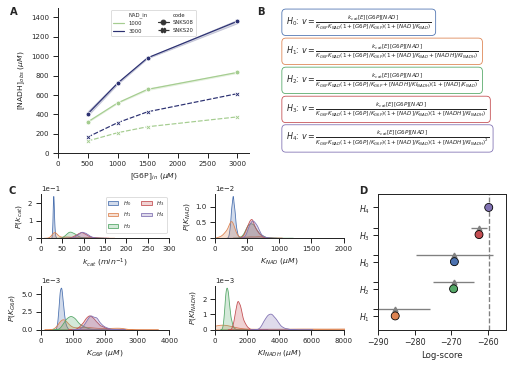

In [55]:
fig = plt.figure(figsize=(XSIZE, YSIZE), constrained_layout=True)
gs0 = fig.add_gridspec(2, 1)

gs = gs0[0].subgridspec(1,2)

ax_1 = fig.add_subplot(gs[0])

sns.lineplot(ax=ax_1, data=data, x='G6P_in', y='NADH_obs', hue="NAD_in", palette='crest', style='code', markers=True)
ax_1.set_xlim(0, 3200)
ax_1.set_ylim(0, 1500)
ax_1.set_xlabel(r"$[$G6P$]_{in}~(\mu M)$")
ax_1.set_ylabel(r"$[$NADH$]_{obs}~(\mu M)$")
ax_1.legend(loc='upper center', fontsize='x-small', ncol=2)

ax_3 = fig.add_subplot(gs[1])
ax_3.axis('off')

ax_3.text(x=-0.15, y=0.9, va='center', ha='left', fontsize=8, bbox=dict(boxstyle='round', fc='white', ec='C0', pad=0.5), 
            s=r"$H_0$: $v = \frac{k_{cat}[E][G6P][NAD]}{K_{G6P}K_{NAD}(1+[G6P]/K_{G6P})(1+[NAD]/K_{NAD})}$")
ax_3.text(x=-0.15, y=0.7, va='center', ha='left', fontsize=8, bbox=dict(boxstyle='round', fc='white', ec='C1', pad=0.5), 
            s=r"$H_1$: $v = \frac{k_{cat}[E][G6P][NAD]}{K_{G6P}K_{NAD}(1+[G6P]/K_{G6P})(1+[NAD]/K_{NAD}+[NADH]/KI_{NADH})}$")
ax_3.text(x=-0.15, y=0.5, va='center', ha='left', fontsize=8, bbox=dict(boxstyle='round', fc='white', ec='C2', pad=0.5), 
            s=r"$H_2$: $v = \frac{k_{cat}[E][G6P][NAD]}{K_{G6P}K_{NAD}(1+[G6P]/K_{G6P}+[NADH]/KI_{NADH})(1+[NAD]/K_{NAD})}$")
ax_3.text(x=-0.15, y=0.3, va='center', ha='left', fontsize=8, bbox=dict(boxstyle='round', fc='white', ec='C3', pad=0.5), 
            s=r"$H_3$: $v = \frac{k_{cat}[E][G6P][NAD]}{K_{G6P}K_{NAD}(1+[G6P]/K_{G6P})(1+[NAD]/K_{NAD})(1+ [NADH]/KI_{NADH})}$")
ax_3.text(x=-0.15, y=0.1, va='center', ha='left', fontsize=8, bbox=dict(boxstyle='round', fc='white', ec='C4', pad=0.5), 
            s=r"$H_4$: $v = \frac{k_{cat}[E][G6P][NAD]}{K_{G6P}K_{NAD}(1+[G6P]/K_{G6P})(1+[NAD]/K_{NAD})(1+ [NADH]/KI_{NADH})^2}$")

ax_1.text(-0.25, 0.95, 'A', transform=ax_1.transAxes, weight="bold", size=10)
ax_3.text(-0.3, 0.95, 'B', transform=ax_3.transAxes, weight="bold", size=10)


gs = gs0[1].subgridspec(2,3)
ax_4 = fig.add_subplot(gs[0,0])
ax_5 = fig.add_subplot(gs[1,0])
ax_6 = fig.add_subplot(gs[0,1])
ax_7 = fig.add_subplot(gs[1,1])

ax_4.ticklabel_format(style='sci', scilimits=(-1,1), axis='y')
ax_5.ticklabel_format(style='sci', scilimits=(-1,1), axis='y')
ax_6.ticklabel_format(style='sci', scilimits=(-1,1), axis='y')
ax_7.ticklabel_format(style='sci', scilimits=(-1,1), axis='y')
for i, post in enumerate(posteriors):
    sns.kdeplot(post['k_cat'], ax=ax_4, fill=True, color=f'C{i}', label=r"$H_{}$".format(i))
ax_4.set_xlabel(r"$k_{cat}~(min^{-1})$")
ax_4.set_ylabel(r"$P(k_{cat})$")
ax_4.set_xlim(0, 300)
ax_4.legend(loc='upper right', ncol=2, markerscale=0.5, fontsize='x-small', title_fontsize='small')

for i, post in enumerate(posteriors):
    sns.kdeplot(post['K_G6P'], ax=ax_5, fill=True, color=f'C{i}')
ax_5.set_xlabel(r"$K_{G6P}~(\mu M)$")
ax_5.set_ylabel(r"$P(K_{G6P})$")
ax_5.set_xlim(0, 4000)

for i, post in enumerate(posteriors):
    sns.kdeplot(post['K_NAD'], ax=ax_6, fill=True, color=f'C{i}')
ax_6.set_xlabel(r"$K_{NAD}~(\mu M)$")
ax_6.set_ylabel(r"$P(K_{NAD})$")
ax_6.set_xlim(0, 2000)

for i, post in enumerate(posteriors):
    try:
        sns.kdeplot(post['KI_NADH'], ax=ax_7, fill=True, color=f'C{i}')
    except KeyError as e:
        print(e)
ax_7.set_xlabel(r"$KI_{NADH}~(\mu M)$")
ax_7.set_ylabel(r"$P(KI_{NADH})$")
ax_7.set_xlim(0, 8000)

sns.despine()

ax_8 = fig.add_subplot(gs[:, 2])

model_comparison = az.compare({
    r'$H_0$': idata_0,
    r'$H_1$': idata_2,
    r'$H_2$': idata_3,
    r'$H_3$': idata_1,
    r'$H_4$': idata_5
}, ic='loo', method='BB-pseudo-BMA')
print(model_comparison)
ax_8 = az.plot_compare(model_comparison, ax=ax_8, insample_dev=False, plot_standard_error=False)
ax_8.scatter(model_comparison["loo"], ax_8.get_yticks()[::2], c=[ "C4", "C3", "C0","C2","C1"], s=64, ec='black', zorder=10)
ax_8.set_xlabel("Log-score")
ax_8.set_xlim(-290, -255)
ax_4.text(-0.25, 1.0, 'C', transform=ax_4.transAxes, weight="bold", size=10)
ax_8.text(-0.15, 1.0, 'D', transform=ax_8.transAxes, weight="bold", size=10)

savefig('fig_mechanisms')
plt.show()

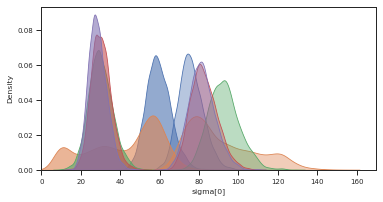

In [56]:
fig, ax = plt.subplots(figsize=(6,3))

for i, post in enumerate(posteriors):
    try:
        sns.kdeplot(post['sigma[0]'], ax=ax, fill=True, color=f'C{i}', alpha=0.4)
        sns.kdeplot(post['sigma[1]'], ax=ax, fill=True, color=f'C{i}', alpha=0.6)
        # sns.kdeplot(post['sigma[2]'], ax=ax, fill=True, color=f'C{i}', alpha=0.8)
    except KeyError as e:
        print(e)

ax.set_xlim(0)
plt.show()

## Old notebook cells

In [10]:
def reactor_test(controls, parameters):
    def reactor(t,c, k, controls):
        G6P, NAD, NADH = c
        v = k.k_cat * controls.E * G6P * NAD / (k.K_G6P*k.K_NAD*(1+G6P/k.K_G6P)*(1+NAD/k.K_NAD + NADH/k.KI_NADH))

        return [
            -v + controls.kf * (controls.G6P_in - G6P),
            -v + controls.kf * (controls.NAD_in - NAD),
            v + controls.kf * (controls.NADH_in - NADH),
        ]

    sol = integrate.solve_ivp(reactor, y0=[controls.G6P_in, controls.NAD_in, controls.NADH_in], t_span=(0, 60), args=(parameters, controls), vectorized=False).y
    return sol

reactor_test(control_inputs.loc[0], posterior_2.loc[0])[2]

NameError: name 'control_inputs' is not defined

In [118]:
import scipy.integrate as integrate
from numba import njit

control_inputs = pd.DataFrame(
    {
        "kf": 0.125, "E": 2.0,
        # "G6P_in": [2000, 3000, 4000, 5000, 2000, 3000, 4000, 5000],
        # "NAD_in": [3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000],
        "G6P_in": [3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000],
        "NAD_in": [3000, 3000, 3000, 3000, 2000, 3000, 4000, 5000],
        "NADH_in": [2000, 3000, 4000, 5000, 3000, 3000, 3000, 3000]
    }
)


def reactor_2(controls, parameters):
    def reactor(t,c, k, controls):
        G6P, NAD, NADH = c
        v = k.k_cat * controls.E * G6P * NAD / (k.K_G6P*k.K_NAD*(1+G6P/k.K_G6P)*(1+NAD/k.K_NAD + NADH/k.KI_NADH))

        return [
            -v + controls.kf * (controls.G6P_in - G6P),
            -v + controls.kf * (controls.NAD_in - NAD),
            v + controls.kf * (controls.NADH_in - NADH),
        ]

    sol = [[integrate.solve_ivp(reactor, y0=[control.G6P_in, control.NAD_in, control.NADH_in], t_span=(0, 60), args=(param, control), vectorized=False).y[2,-1] for i, control in controls.iterrows() ] for j, param in parameters.iterrows()]
    return sol

def reactor_5(controls, parameters):
    def reactor(t,c, k, controls):
        G6P, NAD, NADH = c
        v = k.k_cat * controls.E * G6P * NAD / (k.K_G6P*k.K_NAD*(1+G6P/k.K_G6P)*(1+NAD/k.K_NAD)*(1+ NADH/k.KI_NADH)**2)

        return [
            -v + controls.kf * (controls.G6P_in - G6P),
            -v + controls.kf * (controls.NAD_in - NAD),
            v + controls.kf * (controls.NADH_in - NADH),
        ]

    sol = [[integrate.solve_ivp(reactor, y0=[control.G6P_in, control.NAD_in, control.NADH_in], t_span=(0, 60), args=(param, control), vectorized=False).y[2,-1] for i, control in controls.iterrows() ]for j, param in parameters.iterrows()]
    return sol

pred_2 = reactor_2(control_inputs, posterior_2.sample(200))

pred_5 = reactor_5(control_inputs, posterior_5.sample(200))

'KI_NADH'


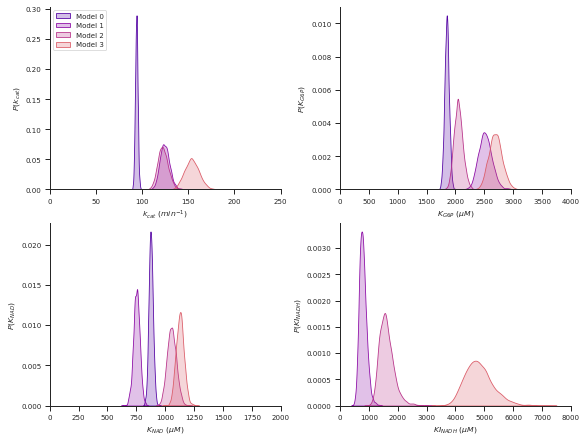

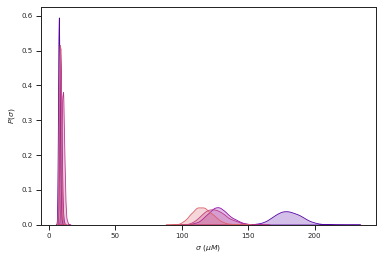

In [ ]:


with sns.color_palette('plasma', n_colors=6):

    fig, axes = plt.subplots(2,2, figsize=(8,6), constrained_layout=True)

    for i, post in enumerate(posteriors):
        sns.kdeplot(post['k_cat'], ax=axes[0][0], fill=True, color=f'C{i}', label=f"Model {i}")

    axes[0][0].set_xlabel(r"$k_{cat}~(min^{-1})$")
    axes[0][0].set_ylabel(r"$P(k_{cat})$")
    axes[0][0].set_xlim(0, 250)
    axes[0][0].legend(loc='upper left')

    for i, post in enumerate(posteriors):
        sns.kdeplot(post['K_G6P'], ax=axes[0][1], fill=True, color=f'C{i}')
    axes[0][1].set_xlabel(r"$K_{G6P}~(\mu M)$")
    axes[0][1].set_ylabel(r"$P(K_{G6P})$")
    axes[0][1].set_xlim(0, 4000)

    for i, post in enumerate(posteriors):
        sns.kdeplot(post['K_NAD'], ax=axes[1][0], fill=True, color=f'C{i}')
    axes[1][0].set_xlabel(r"$K_{NAD}~(\mu M)$")
    axes[1][0].set_ylabel(r"$P(K_{NAD})$")
    axes[1][0].set_xlim(0, 2000)

    for i, post in enumerate(posteriors):
        try:
            sns.kdeplot(post['KI_NADH'], ax=axes[1][1], fill=True, color=f'C{i}')
        except KeyError as e:
            print(e)
    axes[1][1].set_xlabel(r"$KI_{NADH}~(\mu M)$")
    axes[1][1].set_ylabel(r"$P(KI_{NADH})$")
    axes[1][1].set_xlim(0, 8000)

    sns.despine()
    plt.show()

    fig, ax = plt.subplots(figsize=(6,4))
    for i, post in enumerate(posteriors):
        sns.kdeplot(post['sigma[0]'], ax=ax, fill=True, color=f'C{i}')
        sns.kdeplot(post['sigma[1]'], ax=ax, fill=True, color=f'C{i}')
        # sns.kdeplot(post['sigma[0]'], ax=ax, fill=True, color=f'C{i}')

    ax.set_xlabel(r"$\sigma~(\mu M)$")
    ax.set_ylabel(r"$P(\sigma)$")
# ax.set_xlim(0, 2000)

/home/mathieu/anaconda3/envs/phd/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/mathieu/anaconda3/envs/phd/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


         rank         loo      p_loo      d_loo        weight         se  \
model_5     0 -460.086011   9.995511   0.000000  4.308970e-01  20.572814   
model_1     1 -463.559869  10.288714   3.473858  0.000000e+00  21.193274   
model_2     2 -470.557057  11.579056  10.471046  0.000000e+00  21.580386   
model_4     3 -474.838169  11.453683  14.752158  2.548756e-13  20.754832   
model_3     4 -482.743593  12.970784  22.657582  4.585695e-13  22.142735   
model_0     5 -486.556216  12.652510  26.470204  5.691030e-01  35.711813   

               dse  warning loo_scale  
model_5   0.000000    False       log  
model_1   1.915862    False       log  
model_2   5.030913    False       log  
model_4   3.128812    False       log  
model_3   6.605258    False       log  
model_0  23.389344     True       log  


<AxesSubplot:xlabel='Log'>

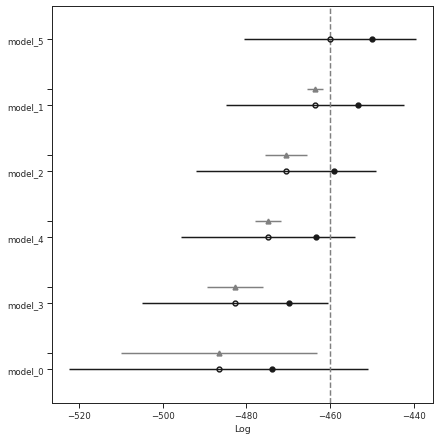

In [ ]:
model_comparison = az.compare({
    'model_0': idata_0,
    'model_1': idata_1,
    'model_2': idata_2,
    'model_3': idata_3,
    'model_4': idata_4,
    'model_5': idata_5,
}, ic='loo')
print(model_comparison)
az.plot_compare(model_comparison)

In [119]:
pred_2_arr = np.array(pred_2) - control_inputs.NADH_in.values
pred_5_arr = np.array(pred_5) - control_inputs.NADH_in.values

(0.0, 587.1013063884353)

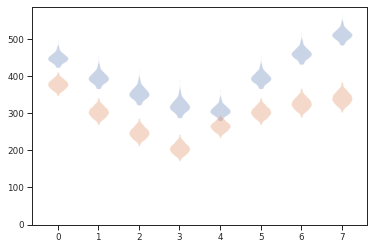

In [120]:
plt.violinplot(pred_2_arr, positions=np.arange(0, len(control_inputs)), showextrema=False)
plt.violinplot(pred_5_arr, positions=np.arange(0, len(control_inputs)), showextrema=False)
plt.ylim(0)